# Probabilistic Learning

<center><img src="images/bayes_net_example.png" width=50%></center>

In [33]:
# Importing the necessary libaries
import sys
sys.path.insert(0, "aux_functions")
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from vis_functions import *
%matplotlib inline

# Loading the dataset
mitbih_test = pd.read_csv("datasets/heartbeat/mitbih_test.csv", header = None)
mitbih_train = pd.read_csv("datasets/heartbeat/mitbih_train.csv", header = None)

# Class dict
class_dict ={
    0.: 'N',
    1.: 'S',
    2.: 'V',
    3.: 'F',
    4.: 'Q'    
}

### Visualizing the data

In [44]:
sample_rate = 125

mitbih_test_X = mitbih_test.iloc[:, :-1]
mitbih_test_Y = mitbih_test.iloc[:, -1].to_frame()

mitbih_train_X = mitbih_train.iloc[:, :-1]
mitbih_train_Y = mitbih_train.iloc[:, -1].to_frame()

time_vec = np.arange(mitbih_test_X.T.shape[0]) * 1/sample_rate

print("mitbih_test_Y shape:", mitbih_test_X.shape)
mitbih_test_X.head(10)

mitbih_test_Y shape: (21892, 187)


,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.000000,0.923664,0.656489,0.195929,0.111959,0.175573,0.122137,0.050891,0.035623,0.055980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.000000,0.797260,0.320548,0.043836,0.049315,0.065753,0.030137,0.008219,0.005479,0.010959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.909408,0.975610,0.533101,0.134146,0.066202,0.000000,0.010453,0.012195,0.031359,0.146341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.927803,0.866359,0.299539,0.000000,0.231951,0.317972,0.274962,0.262673,0.270353,0.268817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.000000,0.914230,0.473684,0.000000,0.064327,0.317739,0.405458,0.391813,0.382066,0.401559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
mitbih_test_Y["class_id"] = mitbih_test_Y.iloc[:, 0]
mitbih_test_Y["class_name"] = mitbih_test_Y.loc[:, "class_id"].apply(lambda x: class_dict[x])
mitbih_test_Y.drop(mitbih_test_Y.columns[0], axis = 1, inplace = True)
print("mitbih_test_Y shape:", mitbih_test_Y.shape)
mitbih_test_Y.head(10)

mitbih_test_Y shape: (21892, 2)


,class_id,class_name
0,0.0,N
1,0.0,N
2,0.0,N
3,0.0,N
4,0.0,N
5,0.0,N
6,0.0,N
7,0.0,N
8,0.0,N
9,0.0,N


In [57]:
mitbih_test_X.T.iloc[:,70].shape[0]

187

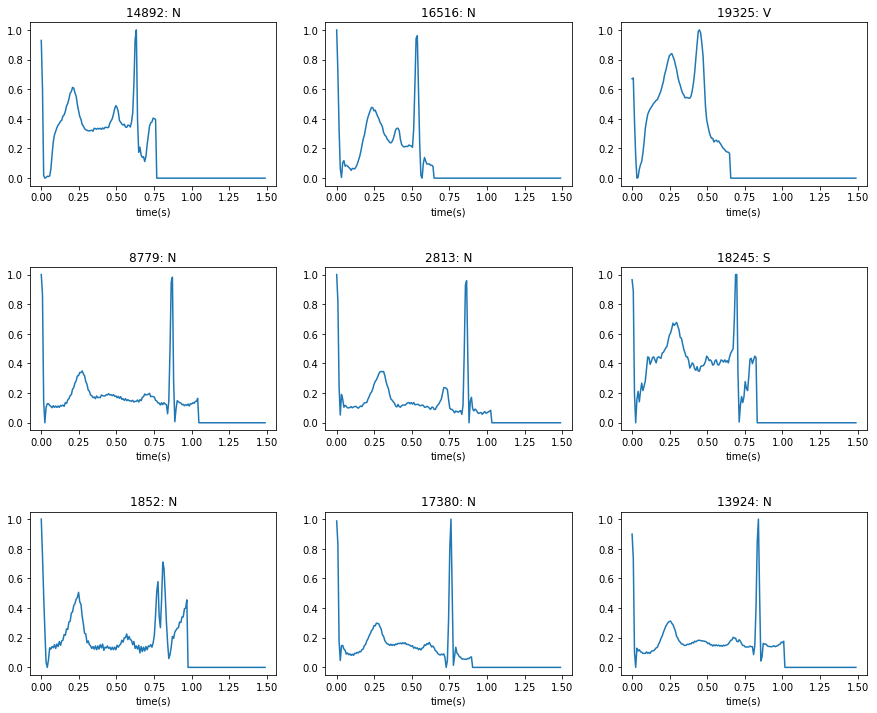

In [58]:
def plot_random(X, Y, xcol, title_col, nplots = 9, ncols = 3, sample_rate = 125):
    rnd_samples = np.random.choice(np.arange(X.shape[1] - 1), nplots)
    
    fig, axes = plt.subplots(nrows=np.int32(np.ceil(nplots/ncols)),
                             ncols = ncols,
                             figsize = (ncols * 5, np.int32(np.ceil(nplots/ncols) * 4)))
    axes = axes.flatten()

    for idx, ax in zip(rnd_samples, axes):
        yvals = X.iloc[:, idx]
        xvals = np.arange(yvals.shape[0]) * (1/sample_rate)
        ax.plot(xvals, yvals)
        ax.legend().remove()
#         X.plot(x = xcol, y = idx, kind = "line", ax = ax, legend = False)
        ax.set_title("".join([str(idx),": ", Y.loc[idx, title_col]]))
        ax.set_xlabel("time(s)")

    plt.subplots_adjust(hspace=0.5)

plot_random(mitbih_test_X.T, mitbih_test_Y, "time", "class_name")

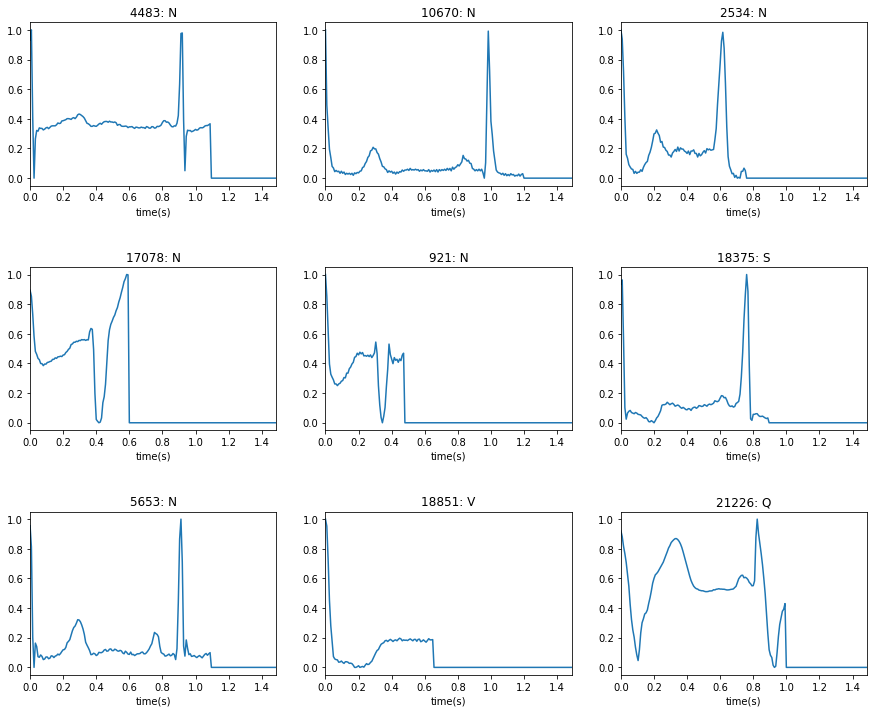

In [20]:
rnd_samples = np.random.choice(np.arange(mitbih_test_X.shape[0]), 9)
num_plots = 9
plt_cols = 3

fig, axes = plt.subplots(nrows=np.int32(np.ceil(num_plots/plt_cols)), ncols=plt_cols, figsize = (plt_cols * 5, np.int32(np.ceil(num_plots/plt_cols) * 4)))
axes = axes.flatten()

for idx, ax in zip(rnd_samples, axes):
    mitbih_test_X.T.plot(x = "time", y = idx, kind = "line", ax = ax, legend = False)
    ax.set_title("".join([str(idx),": ",mitbih_test_Y.loc[idx, "class_name"]]))
    ax.set_xlabel("time(s)")
    
plt.subplots_adjust(hspace=0.5)